<a href="https://colab.research.google.com/github/samymessal/EEG_octo/blob/full_sleep_multi_label_classification/files/full_sleep_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep Spindle Study

## Building Model

In this notebook, we build a model to detect the presence of sleep spindles in the entire EEG recording.
        

In [58]:
!pip install mne -q
!pip install vmdpy -q
!pip install yasa -q
!pip install imbalanced-learn -q

In [59]:
!git clone -b full_sleep_multi_label_classification https://github.com/samymessal/EEG_octo
import sys
sys.path.append('/content/EEG_octo/files')

fatal: destination path 'EEG_octo' already exists and is not an empty directory.



## Imports

We will import the necessary libraries that are needed for processing the data, building the model, and evaluating its performance.
        

In [60]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.io import loadmat
from scipy.signal import detrend
import yasa
from collections import namedtuple
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split



DEFAULT_DIVIDER = 10000000

### Download data

Using the `processed_data` function from the previous step to download our concatenated raw with its correspondent preprocessing and features.

In [61]:
 Data = namedtuple("Data", "X Y")

def load_eeg_data(mat_file_path):
    # Load the .mat file using scipy
    mat = loadmat(mat_file_path)
    # Extract EEG data
    return mat['EEG'][0, 0]['data']

def mk_raw_obj(eeg_data, sfreq=250):
    info = mne.create_info(
        ch_names=[f'EEG{i}' for i in range(len(eeg_data))],
        sfreq=sfreq,
        ch_types=['eeg' for _ in range(len(eeg_data))]
    )

    return mne.io.RawArray(eeg_data, info, verbose=0)

def load_data(file_path, labels_path):
    raw_mat = load_eeg_data(file_path)
    raw = mk_raw_obj(raw_mat)
    raw_data = raw.get_data()
    labels = pd.read_csv(labels_path)
    labels.sort_values("Timestamp", inplace=True)
    return raw, raw_data, labels

def mne_events_from_labels_df(recording_raw_obj: mne.io.Raw, labels_df: pd.DataFrame, target_label: str,):
    presence_mask = labels_df[target_label] == 1
    nb_events = len(labels_df[presence_mask])

    return np.column_stack((labels_df['Timestamp'][presence_mask], np.ones(nb_events), np.ones(nb_events)))


def preprocess_data(recording_data,
                    frequency_band,
                    sampling_freq,
                    resampling_freq,
                    labels_df,
                    target_label,
                    window_size_in_seconds):
    # Detrending
    recording_data = detrend(recording_data)

    # Create mne raw obj
    recording_raw_obj = mk_raw_obj(recording_data)
    events = mne_events_from_labels_df(recording_raw_obj, labels_df, target_label)

    # Resampling
    recording_raw_obj, events = recording_raw_obj.resample(resampling_freq, events=events)
    labels_df = pd.DataFrame(events, columns=["Timestamp", "ignore", target_label])

    return recording_raw_obj, labels_df

def hypnogram_propas(recording_raw_obj, sampling_freq=250):
    """
    Computes the propabilites of the each sleep stages at each 30s epoch.
    Then, upsamples the probabilites to match the shape of the recording.
    ### Parameters:
    recording_data: ndarray of the recording
    ### Returns:
    Tuple of shape four, each item is a 1D array of the probability of a sleep stage at a given timestamp.
    Four for the four sleep stages: awake, REM, NREM1, NREM2, NREM3
    """
    # For some reason, yasa doesn't work properly with the unscaled data.
    scalled_raw_obj = mk_raw_obj(recording_raw_obj.get_data() / DEFAULT_DIVIDER, sfreq=sampling_freq)
    sls = yasa.SleepStaging(scalled_raw_obj, eeg_name="EEG0")
    hypno_proba = sls.predict_proba()
    return [yasa.hypno_upsample_to_data(hypno_proba[column], 1/30, scalled_raw_obj, verbose=False) for column in hypno_proba.columns]

def window_data(data, window_size):
    num_windows = len(data) - window_size + 1
    return np.array([data[i:i+window_size] for i in range(num_windows)]), num_windows

def load_and_preprocess_data(
        recording_files,
        labels_files,
        target_label,
        resampling_freq,
        sampling_freq,
        frequency_band,
        window_size_in_seconds,):
    time_series = []
    target_timeseries = []
    window_size = int(window_size_in_seconds * resampling_freq)
    for recording_file, labels_file in zip(recording_files, labels_files):
        # Loading
        labels_df = pd.read_csv(labels_file)
        recording_data = load_eeg_data(recording_file)

        # Preprocessing
        preprocessed_recording_raw_obj, labels_df = preprocess_data(
            recording_data,
            frequency_band,
            sampling_freq,
            resampling_freq,
            labels_df,
            target_label,
            window_size_in_seconds,
            )

        # Feature engineering
        hypno_propas = hypnogram_propas(preprocessed_recording_raw_obj, sampling_freq=sampling_freq)

        # Features formatting
        time_serie = np.column_stack((preprocessed_recording_raw_obj.get_data().squeeze(), *hypno_propas))
        target_timeserie = np.zeros(time_serie.shape[0])
        for timestamp in labels_df["Timestamp"]:
          target_timeserie[int(timestamp)] = 1
        windowed_time_serie, num_windows = window_data(time_serie, window_size)
        target_timeserie = target_timeserie[:windowed_time_serie.shape[0]]
        time_series.append(windowed_time_serie)
        target_timeseries.append(target_timeserie)

    concat_timeseries = np.concatenate(time_series, axis=0)
    concat_target_timeseries = np.concatenate(target_timeseries, axis=0)
    print("concat_timeseries:", concat_timeseries.shape)
    print("concat_target_timeseries:", concat_target_timeseries.shape)
    return Data(X=concat_timeseries, Y=concat_target_timeseries), window_size


data, window_size = load_and_preprocess_data(
    ["./EEG_octo/dataset/train_S002_night1_hackathon_raw.mat",
    "./EEG_octo/dataset/train_S003_night5_hackathon_raw.mat"
    ],
    ["./EEG_octo/dataset/train_S002_labeled.csv",
    "./EEG_octo/dataset/train_S003_labeled.csv"
    ],
    sampling_freq=250,
    resampling_freq=20,
    target_label="SS1",
    frequency_band=(8, 16),
    window_size_in_seconds=2.5,
)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


concat_timeseries: (858952, 50, 6)
concat_target_timeseries: (858952,)



#### Model

The chosen model is an LSTM, since we are dealing with timeframes, LSTM are known to deal well with time depending samples. A k-cross validation is implemented, partitioning the data into 5 parts and alterning between the 4 parts for training and the 1 for testing.
        

In [62]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split

def seperate_test_and_train_data(X, Y, test_size_ratio):
    positive_indices = np.where(Y == 1)[0]
    negative_indices = np.where(Y == 0)[0]
    test_size = int(len(Y) * test_size_ratio)
    positive_ratio = len(positive_indices) / len(Y)
    nb_positive_samples_in_test = int(test_size * positive_ratio)
    nb_negative_samples_in_test = test_size - nb_positive_samples_in_test

    subset_positive_samples = np.random.choice(positive_indices, nb_positive_samples_in_test, replace=len(positive_indices) < nb_positive_samples_in_test)
    subset_negative_samples = np.random.choice(negative_indices, nb_negative_samples_in_test, replace=len(negative_indices) < nb_negative_samples_in_test)

    subset_indices = np.concatenate([subset_positive_samples, subset_negative_samples])
    X_subset = X[subset_indices]
    Y_subset = Y[subset_indices]

    X_complement, Y_complement = X[~np.isin(np.arange(len(X)), subset_indices)], Y[~np.isin(np.arange(len(Y)), subset_indices)]

    return X_subset, Y_subset, X_complement, Y_complement

def resample(X, Y, target, nb_desired_samples):
    target_indices = np.where(Y == target)[0]
    other_target_indices = np.where(Y != target)[0]
    resampled_target_indices = np.random.choice(target_indices, nb_desired_samples, replace=len(target_indices) < nb_desired_samples)
    resampled_indices = np.concatenate((resampled_target_indices, other_target_indices))

    X_resampled = X[resampled_indices]
    Y_resampled = Y[resampled_indices]
    return X_resampled, Y_resampled

def datasets_from_preprocessed_data(X, Y, test_size_ratio=0.15, batch_size=128, shuffle=False):
    X_subset, Y_subset, X_complement, Y_complement = seperate_test_and_train_data(X, Y, test_size_ratio)

    # Balancing the dataset
    OVER_REP_SAMPLES_RATIO = 0.5
    over_rep_samples = int(OVER_REP_SAMPLES_RATIO * len(X_complement))
    UNDER_REP_SAMPLES_RATIO = 0.5
    UNDER_REP_SAMPLES = int(over_rep_samples * UNDER_REP_SAMPLES_RATIO)

    X_train, Y_train = resample(X_complement, Y_complement, 0, over_rep_samples)
    X_train, Y_train = resample(X_train, Y_train, 1, UNDER_REP_SAMPLES)

    # Create PyTorch datasets
    train_dataset = CustomDataset(X_train, Y_train)
    test_dataset = CustomDataset(X_subset, Y_subset)

    return train_dataset, test_dataset

# Create datasets
train_dataset, test_dataset = datasets_from_preprocessed_data(data.X, data.Y)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [79]:
class MyModel(nn.Module):
    def __init__(self, cnn_input_size, num_classes, window_size, dropout_rate=0.2):
        super(MyModel, self).__init__()

        # Layer Normalization before the first CNN layer
        self.cnn_norm = nn.LayerNorm((cnn_input_size, window_size))

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=cnn_input_size, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Normalization after Conv2
        self.conv3 = nn.Conv1d(64, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)  # Batch Normalization after Conv3

        # Dropout layer
        self.dropout_cnn = nn.Dropout(dropout_rate)

        # Fully Connected layers
        self.fc1 = nn.Linear(773, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_classes)

        # Dropout layers for fully connected
        self.dropout_fc = nn.Dropout(dropout_rate)

    def forward(self, x):
        # CNN
        x1 = x[:, 0, :].unsqueeze(1)
        x1 = self.cnn_norm(x1)
        x1 = F.relu(self.conv1(x1))
        x1 = self.dropout_cnn(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.dropout_cnn(x1)
        x1 = F.relu(self.conv3(x1))
        x1 = self.dropout_cnn(x1)
        x1 = x1.view(x1.size(0), -1) # Flatten the output
        # Additional Inputs
        x2 = x[:, 0, 1:]  # Ensure this aligns with your actual input structure

        # Concatenate
        x = torch.cat((x1, x2), dim=1)

        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = torch.sigmoid(self.output(x))
        return x

In [78]:
import torch
from sklearn.metrics import f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(cnn_input_size=1, num_classes=1, window_size=window_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

num_epochs = 20

# To store F1 scores for plotting
train_f1_scores = []
test_f1_scores = []

def eval_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch.to(device, dtype=torch.float), Y_batch.to(device, dtype=torch.float).unsqueeze(1)
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            all_labels.append(Y_batch.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_predictions = np.concatenate(all_predictions)
    return f1_score(all_labels, all_predictions)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_labels = []
    all_predictions = []

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device, dtype=torch.float)
        Y_batch = Y_batch.to(device, dtype=torch.float).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predictions = (outputs > 0.5).float()
        all_labels.append(Y_batch.cpu())
        all_predictions.append(predictions.cpu())

    average_loss = total_loss / len(train_loader)
    all_labels = torch.cat(all_labels).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    train_f1 = f1_score(all_labels, all_predictions)
    train_f1_scores.append(train_f1)

    test_f1 = eval_model(model, test_loader)
    test_f1_scores.append(test_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}')

RuntimeError: Given normalized_shape=[1], expected input with shape [*, 1], but got input of size[128, 1, 6]

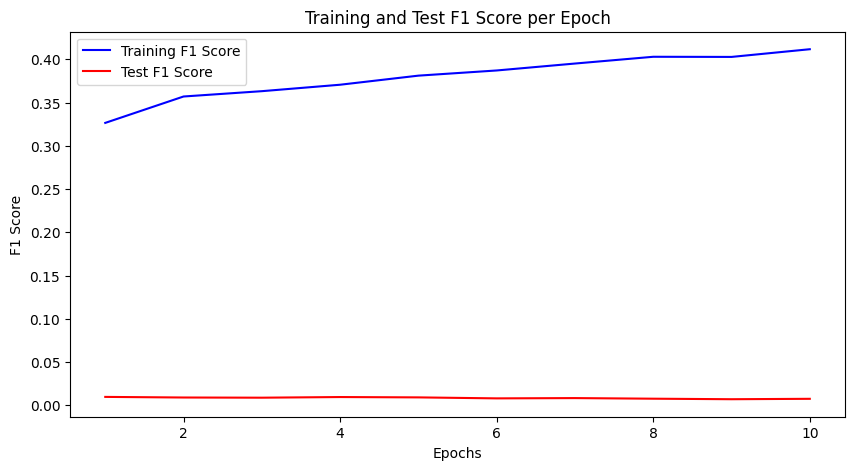

In [74]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores, 'b-', label='Training F1 Score')
plt.plot(epochs, test_f1_scores, 'r-', label='Test F1 Score')
plt.title('Training and Test F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
